In [1]:
import pandas as pd

# Load the CSVs
fake_df = pd.read_csv("../data/Fake.csv")
real_df = pd.read_csv("../data/True.csv")

# Add labels: fake = 0, real = 1
fake_df["label"] = 0
real_df["label"] = 1

# Merge them
df = pd.concat([fake_df, real_df], ignore_index=True)

# Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Show top rows
df.head()


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [3]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Only clean the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# Preview cleaned data
df[['text', 'clean_text']].head()


,text,clean_text
0,"21st Century Wire says Ben Stein, reputable pr...",st century wire says ben stein reputable profe...
1,WASHINGTON (Reuters) - U.S. President Donald T...,washington reuters us president donald trump r...
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,reuters puerto rico governor ricardo rossello ...
3,"On Monday, Donald Trump once again embarrassed...",monday donald trump embarrassed country accide...
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",glasgow scotland reuters us presidential candi...


In [5]:
!pip install wordcloud


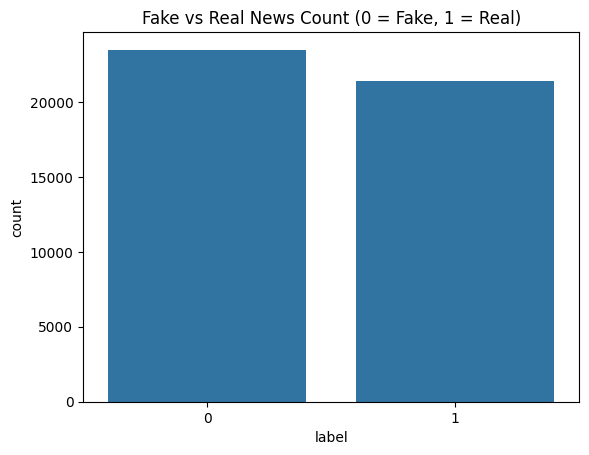

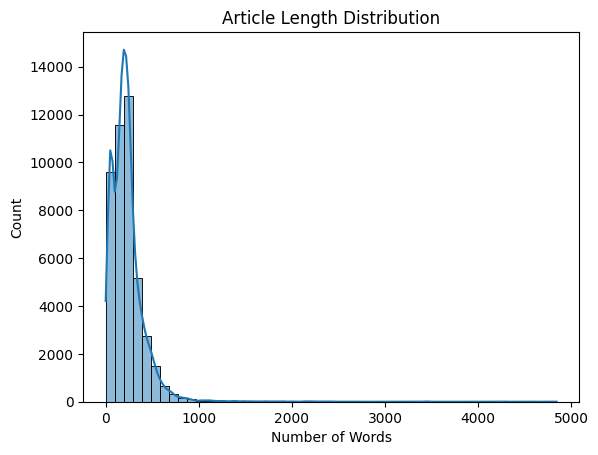

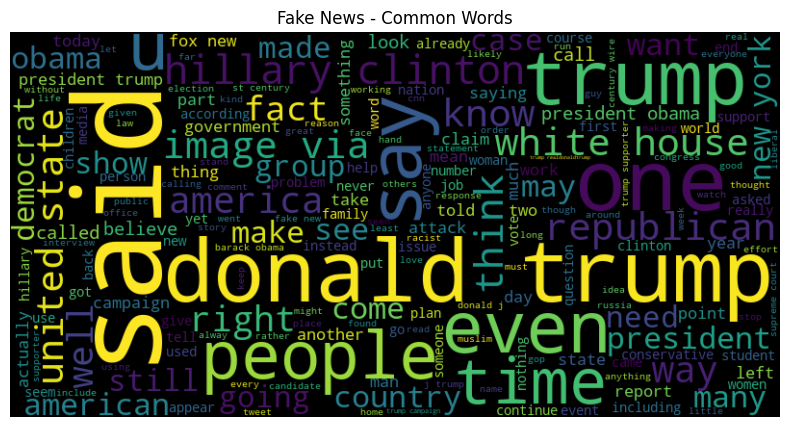

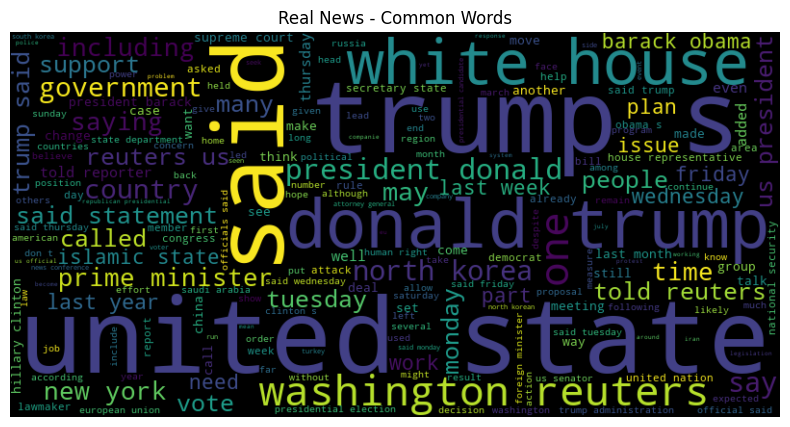

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# CLASS BALANCE
sns.countplot(x='label', data=df)
plt.title("Fake vs Real News Count (0 = Fake, 1 = Real)")
plt.show()

# TEXT LENGTH DISTRIBUTION
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], kde=True, bins=50)
plt.title("Article Length Distribution")
plt.xlabel("Number of Words")
plt.show()

# WORDCLOUDS
def show_wordcloud(data, title):
    text = ' '.join(data)
    wc = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# WordCloud for FAKE NEWS
show_wordcloud(df[df.label == 0]['clean_text'], "Fake News - Common Words")

# WordCloud for REAL NEWS
show_wordcloud(df[df.label == 1]['clean_text'], "Real News - Common Words")


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract features and labels
X = df['clean_text']
y = df['label']

# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_vectors = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (35918, 5000)
Test shape: (8980, 5000)


Accuracy: 0.9865

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4710
           1       0.98      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



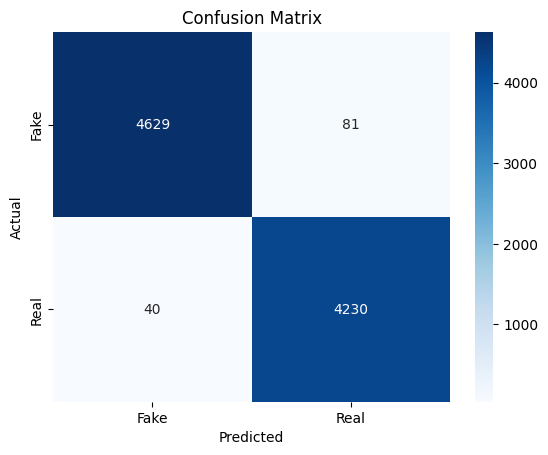

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [12]:
import pickle

# Save model
with open(r"G:\Learning\fake_news_detector\models\model_text.pkl", "wb") as f:
    pickle.dump(model, f)

# Save vectorizer
with open(r"G:\Learning\fake_news_detector\models\vectorizer_text.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("✅ Model and vectorizer saved.")


✅ Model and vectorizer saved.
